In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
# npz1 = np.load(NPZ_DIR + '/20200724_COH_BC.npz')
# npz2 = np.load(NPZ_DIR + '/20200720_all_data_512x512.npz')
# combined_x = np.concatenate((npz1['X'], npz2['X']), axis=0)
# combined_y = np.concatenate((npz1['y'], npz2['y']), axis=0)

# print(combined_x.shape, combined_y.shape)

(960, 512, 512, 2) (960, 512, 512, 1)


In [4]:
# np.savez_compressed(NPZ_DIR + '/20200730_all_data_512x512.npz', X=combined_x, y=combined_y)

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200730_all_data_512x512"

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

X.shape: (864, 512, 512, 2)
y.shape: (864, 512, 512, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


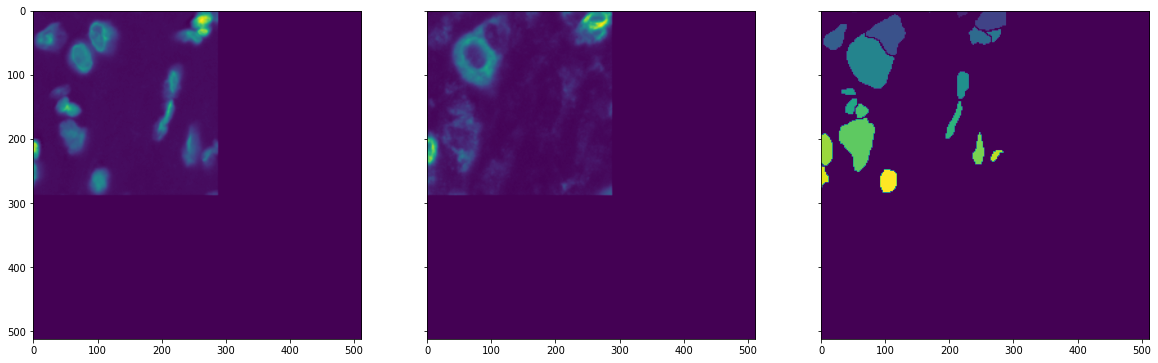

In [4]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 107
axes[0].imshow(X_train[idx,:,:,0].astype('float32'))
axes[1].imshow(X_train[idx,:,:,1].astype('float32'))
axes[2].imshow(y_train[idx,:,:,0].astype('float32'))
print(np.unique(y_train[idx]))

In [6]:
k=128
X_train = phase_preprocess(X_train, k)
X_val = phase_preprocess(X_val, k)

In [7]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0808 23:13:52.980001 140484351838016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 3s 0us/step


In [7]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 150  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 30  # throw out images with fewer than this many objects
seed=0
model_name

'20200803_all_data_normalized_512x512_deep_watershed'

In [8]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.CroppingDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    crop_size=(256, 256))
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

W0803 22:02:17.512557 140360912729920 semantic.py:158] Removing 415 of 2071 images with fewer than 30 objects.
W0803 22:03:14.324995 140360912729920 semantic.py:158] Removing 43 of 231 images with fewer than 30 objects.


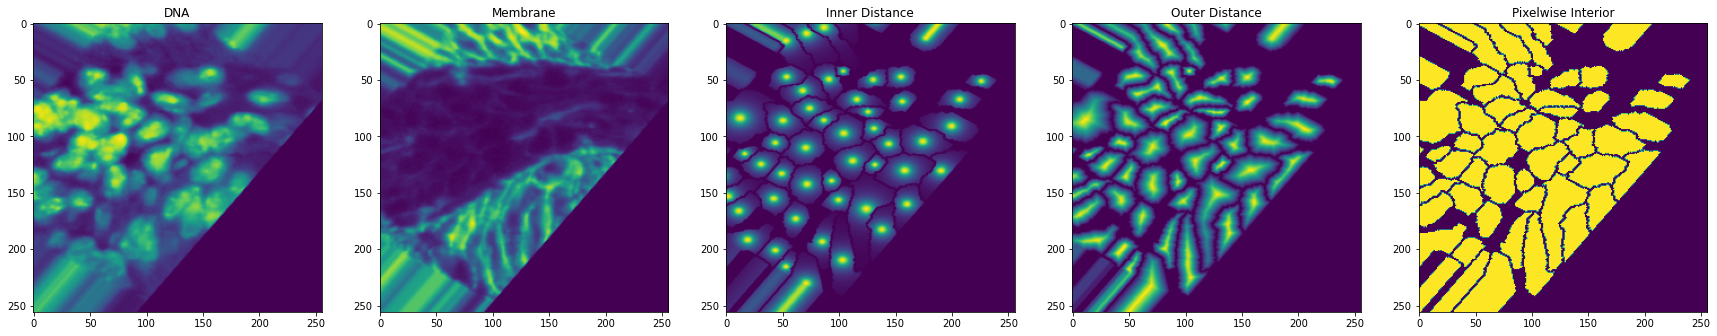

In [21]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(30, 30))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Membrane')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(pixelwise[0, ..., 1])
axes[4].set_title('Pixelwise Interior')

plt.show()

In [22]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [23]:
new_model.compile(loss=loss, optimizer=optimizer)

In [24]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/150


W0803 22:04:20.862259 140360912729920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/207 [..............................] - ETA: 1:52:56 - loss: 1.4589 - semantic_0_loss: 0.2726 - semantic_1_loss: 1.1598 - semantic_2_loss: 0.0131 - semantic_3_loss: 0.0134

W0803 22:04:53.836771 140360912729920 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.400073). Check your callbacks.


  2/207 [..............................] - ETA: 57:03 - loss: 1.3572 - semantic_0_loss: 0.2610 - semantic_1_loss: 1.0713 - semantic_2_loss: 0.0123 - semantic_3_loss: 0.0126  

W0803 22:04:54.034935 140360912729920 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.224296). Check your callbacks.


206/207 [============================>.] - ETA: 0s - loss: 0.1101 - semantic_0_loss: 0.0232 - semantic_1_loss: 0.0769 - semantic_2_loss: 0.0030 - semantic_3_loss: 0.0069
Epoch 00001: val_loss improved from inf to 0.21492, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_deep_watershed.h5
207/207 [==============================] - 146s 704ms/step - loss: 0.1097 - semantic_0_loss: 0.0231 - semantic_1_loss: 0.0767 - semantic_2_loss: 0.0030 - semantic_3_loss: 0.0069 - val_loss: 0.2149 - val_semantic_0_loss: 0.0361 - val_semantic_1_loss: 0.0754 - val_semantic_2_loss: 0.0485 - val_semantic_3_loss: 0.0550
Epoch 2/150
206/207 [============================>.] - ETA: 0s - loss: 0.0401 - semantic_0_loss: 0.0119 - semantic_1_loss: 0.0204 - semantic_2_loss: 0.0020 - semantic_3_loss: 0.0057
Epoch 00002: val_loss improved from 0.21492 to 0.17748, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_deep_watershed.h5

Epoch 14/150
206/207 [============================>.] - ETA: 0s - loss: 0.0305 - semantic_0_loss: 0.0089 - semantic_1_loss: 0.0150 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0049
Epoch 00014: val_loss improved from 0.02784 to 0.02768, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_deep_watershed.h5
207/207 [==============================] - 65s 316ms/step - loss: 0.0304 - semantic_0_loss: 0.0089 - semantic_1_loss: 0.0150 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0049 - val_loss: 0.0277 - val_semantic_0_loss: 0.0080 - val_semantic_1_loss: 0.0136 - val_semantic_2_loss: 0.0015 - val_semantic_3_loss: 0.0046
Epoch 15/150
206/207 [============================>.] - ETA: 0s - loss: 0.0301 - semantic_0_loss: 0.0088 - semantic_1_loss: 0.0148 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0048
Epoch 00015: val_loss did not improve from 0.02768
207/207 [==============================] - 62s 302ms/step - loss: 0.0301 - semantic_0_loss: 0.0088 

Epoch 28/150
206/207 [============================>.] - ETA: 0s - loss: 0.0291 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0143 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0048
Epoch 00028: val_loss did not improve from 0.02585
207/207 [==============================] - 62s 300ms/step - loss: 0.0290 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0142 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0048 - val_loss: 0.0270 - val_semantic_0_loss: 0.0079 - val_semantic_1_loss: 0.0133 - val_semantic_2_loss: 0.0014 - val_semantic_3_loss: 0.0044
Epoch 29/150
206/207 [============================>.] - ETA: 0s - loss: 0.0292 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0144 - semantic_2_loss: 0.0016 - semantic_3_loss: 0.0047
Epoch 00029: val_loss improved from 0.02585 to 0.02566, saving model to /data/models/20200619_production_updates/20200803_all_data_normalized_512x512_deep_watershed.h5
207/207 [==============================] - 65s 314ms/step - loss: 0.0293 - semantic_0_loss: 0.0085 

KeyboardInterrupt: 

In [8]:
new_model.load_weights(os.path.join(MODEL_DIR, '20200803_all_data_normalized_512x512_deep_watershed' + '.h5'))

In [105]:
# from deepcell.applications import MultiplexSegmentation
# app = MultiplexSegmentation(use_pretrained_weights=False)
# # app.model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))
# app.model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')
# model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')

In [9]:
inner_distance, outer_distance, fgbg, pixelwise = new_model.predict(X_val[:30, :256, :256, :])

In [10]:
import numpy as np
import scipy.ndimage as nd

from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.morphology import watershed, remove_small_objects, h_maxima, disk
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import erode_edges
def deep_watershed_mibi(model_output,
                        min_distance=10,
                        maxima_threshold=0.1,
                        interior_threshold=0.2,
                        exclude_border=False,
                        small_objects_threshold=0,
                        interior_model='pixelwise-interior',
                        maxima_model='inner-distance',
                        interior_model_smooth=1,
                        maxima_model_smooth=1,
                       height=0.25,
                       radius=5):
    """Postprocessing function for multiplexed deep watershed models. Thresholds the inner
    distance prediction to find cell centroids, which are used to seed a marker
    based watershed of the pixelwise interior prediction.
    Args:
        model_output (dict): DeepWatershed model output. A dictionary containing key: value pairs
            with the transform name and the corresponding output. Currently supported keys:
            - inner_distance: Prediction for the inner distance transform.
            - outer_distance: Prediction for the outer distance transform.
            - fgbg: Foreground prediction for the foregound/background transform.
            - pixelwise_interior: Interior prediction for the interior/border/background transform.
        min_distance (int): Minimum allowable distance between two object maxima.
        maxima_threshold (float): Threshold for the maxima prediction.
        interior_threshold (float): Threshold for the interior prediction.
        exclude_border (bool): Whether to include centroid detections at the border.
        small_objects_threshold (int): Removes objects smaller than this size.
        interior_model: semantic head to use to predict interior of each object
        maxima_model: semantic head to use to predict maxima of each object
        interior_model_smooth: smoothing factor to apply to interior model predictions
        maxima_model_smooth: smoothing factor to apply to maxima model predictions
    Returns:
        numpy.array: Uniquely labeled mask.
    Raises:
        ValueError: if interior_model or maxima_model names not in valid_model_names
        ValueError: if interior_model or maxima_model predictions do not have length 4
    """

    interior_model, maxima_model = interior_model.lower(), maxima_model.lower()

    valid_model_names = {'inner-distance', 'outer-distance', 'fgbg-fg', 'pixelwise-interior'}

    for name, model in zip(['interior_model', 'maxima_model'], [interior_model, maxima_model]):
        if model not in valid_model_names:
            raise ValueError('{} must be one of {}, got {}'.format(
                name, valid_model_names, model))

    interior_predictions = model_output[interior_model]
    maxima_predictions = model_output[maxima_model]

    zipped = zip(['interior_prediction', 'maxima_prediction'],
                 (interior_predictions, maxima_predictions))
    for name, arr in zipped:
        if len(arr.shape) != 4:
            raise ValueError('Model output must be of length 4. The {} model '
                             'provided was of shape {}'.format(name, arr.shape))

    label_images = []
    for batch in range(interior_predictions.shape[0]):
        interior_batch = interior_predictions[batch, ..., 0]
        interior_batch = nd.gaussian_filter(interior_batch, interior_model_smooth)
        maxima_batch = maxima_predictions[batch, ..., 0]
        maxima_batch = nd.gaussian_filter(maxima_batch, maxima_model_smooth)

        markers = h_maxima(image=maxima_batch, h=height, selem=disk(radius))
        markers = label(markers)

        label_image = watershed(-interior_batch,
                                markers,
                                mask=interior_batch > interior_threshold,
                                watershed_line=0)

        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        label_images.append(label_image)

    label_images = np.stack(label_images, axis=0)
    label_images = np.expand_dims(label_images, axis=-1)

    return label_images

In [11]:
labeled_images = deep_watershed_mibi({'inner-distance': inner_distance,
                                     'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                     maxima_threshold=0.02, maxima_model_smooth=0,
                                    interior_threshold=0.3, min_distance=5,
                                    height=0.1, radius=5)

In [12]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [13]:
RGB_data = make_color_overlay(X_val[:, :256, :256, :])
true_overlay = make_outline_overlay(RGB_data, y_val[:, :256, :256, 0])

In [16]:
predicted_overlay = make_outline_overlay(RGB_data[:30], labeled_images[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until
W0808 23:16:11.690371 140484351838016 image.py:717] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0808 23:16:11.693668 140484351838016 image.py:717] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


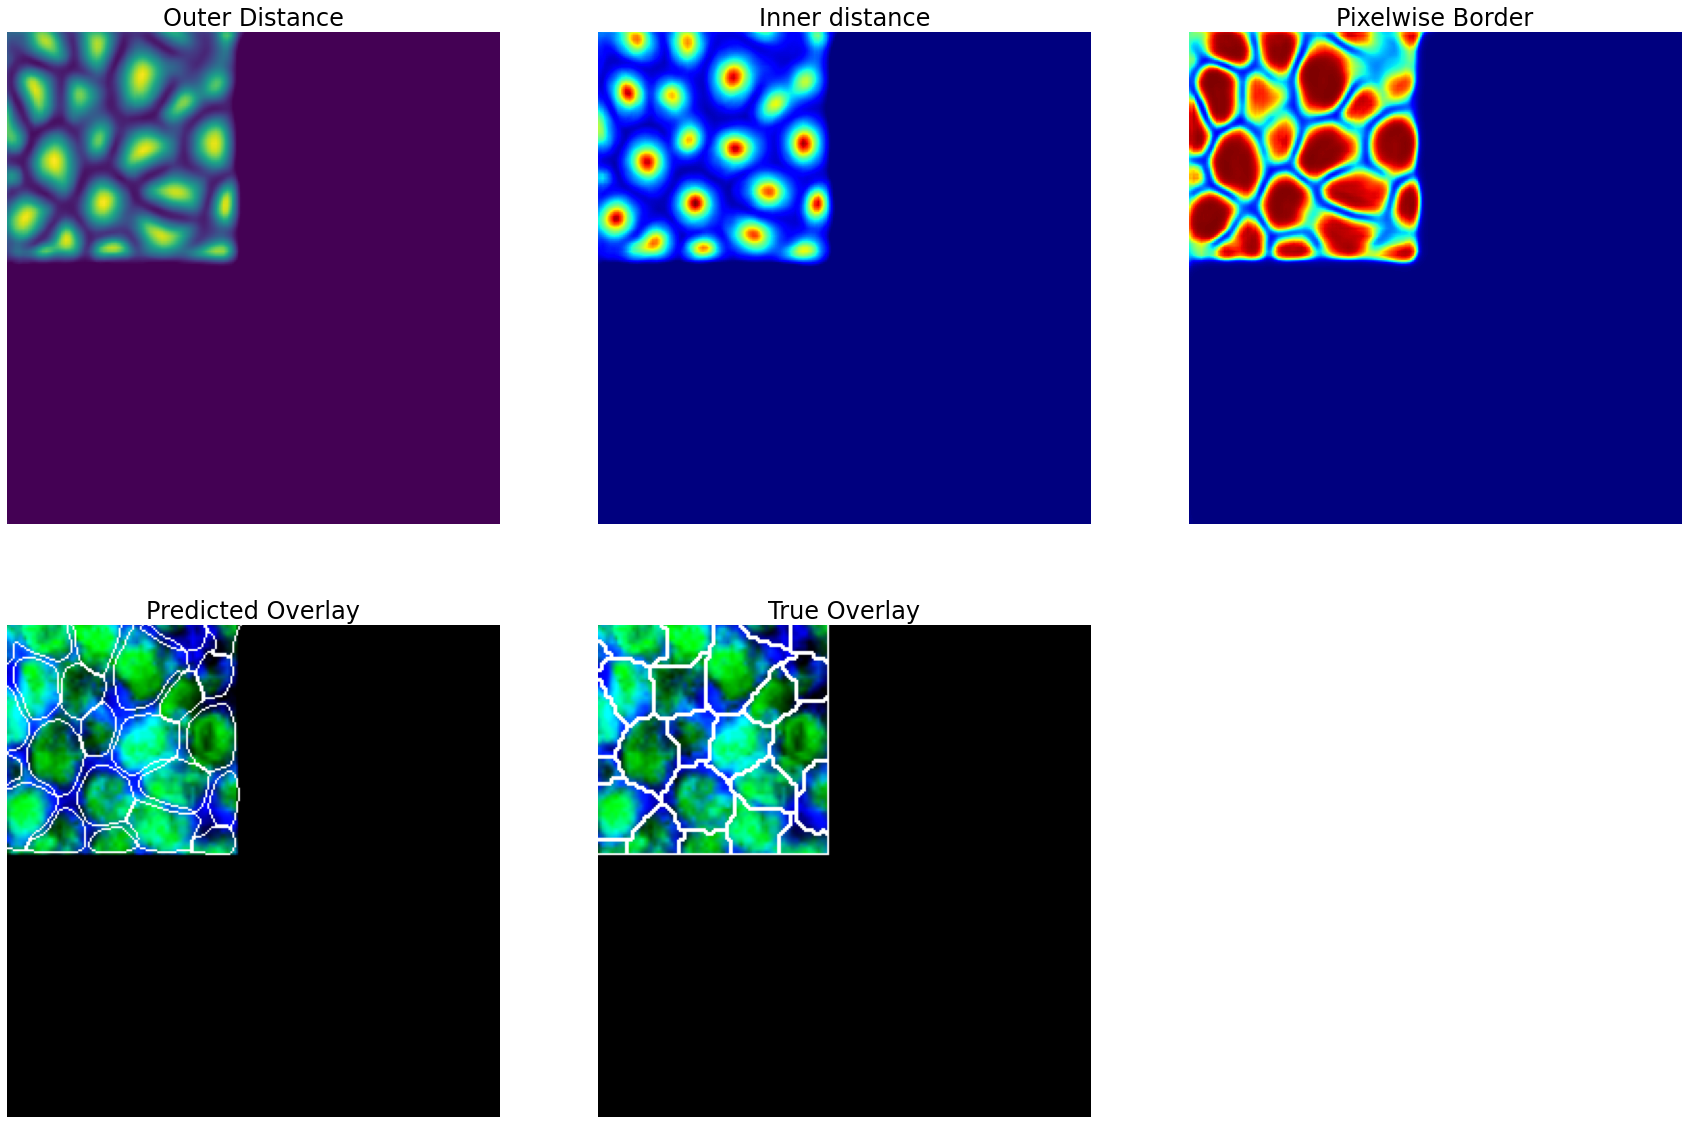

In [18]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [20]
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(outer_distance[index[0],..., 0])
axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
axes[2].imshow(pixelwise[index[0],...,1], cmap='jet')
axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Outer Distance', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [5]:
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation()
app_output = app.predict(image=X_val[:10])

W0809 00:07:46.436294 140067825907520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
from deepcell_toolbox.metrics import Metrics
m = Metrics('human vs human', seg=False)
m.calc_object_stats(y_true=y_val[:10, :, :, 0], y_pred=app_output[:, :, :, 0])
recall = m.stats['correct_detections'].sum() / m.stats['n_true'].sum()
precision = m.stats['correct_detections'].sum() / m.stats['n_pred'].sum()
f1 = 2 * precision * recall / (precision + recall)
print(f1)


____________Object-based statistics____________

Number of true cells:		 3618
Number of predicted cells:	 2834

Correct detections:  1906	Recall: 52.68103924820342598422939772717654705047607421875%
Incorrect detections: 928	Precision: 67.2547635850388161316004698164761066436767578125%

Gained detections: 300	Perc Error: 23.734177215189873777489992789924144744873046875%
Missed detections: 460	Perc Error: 36.392405063291136002590064890682697296142578125%
Merges: 397		Perc Error: 31.408227848101265777813750901259481906890869140625%
Splits: 50		Perc Error: 3.955696202531645777611402081674896180629730224609375%
Catastrophes: 57		Perc Error: 4.50949367088607555587032038602046668529510498046875%

Gained detections from splits: 55
Missed detections from merges: 615
True detections involved in catastrophes: 26
Predicted detections involved in catastrophes: 19 

Average Pixel IOU (Jaccard Index): 0.82338717453549625790998334196046926081180572509765625 

0.5908245505269685


In [35]:
X_train.shape

(2071, 512, 512, 2)